In [2]:
# import libraries
import tensorflow as tf # for modell training
import matplotlib.pyplot as plt # to show graphical results
from matplotlib.ticker import MaxNLocator

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# own modules
import modules.config as config
from modules.ai_dataset import ai_dataset
from modules.export_trained_model import export_trained_model

In [4]:
# import training and testing data
test_data = ai_dataset(config.TEST_DATA, config.IMG_SIZE, True)
training_data = ai_dataset(config.TRAINING_DATA, config.IMG_SIZE, True)

 52%|█████████████████████████████████████████▌                                      | 52/100 [00:00<00:00, 510.47it/s]

Errors: 0; Exceptions: 0


  0%|▎                                                                             | 51/12400 [00:00<00:24, 503.14it/s]

Errors: 0; Exceptions: 0
200 Images ready


  0%|▎                                                                             | 49/12400 [00:00<00:25, 476.40it/s]

Errors: 24; Exceptions: 0


100%|███████████████████████████████████████████████████████████████████████████| 12400/12400 [00:25<00:00, 478.90it/s]


Errors: 30; Exceptions: 0
24746 Images ready


In [5]:
training_data.get_status()

Image Data: (24746, 30, 30, 3)
Label Data: (24746,)
Class labels: dict_items([('Cat', 0), ('Dog', 1)])


In [6]:
test_data.get_status()

Image Data: (200, 30, 30, 3)
Label Data: (200,)
Class labels: dict_items([('Cat', 0), ('Dog', 1)])


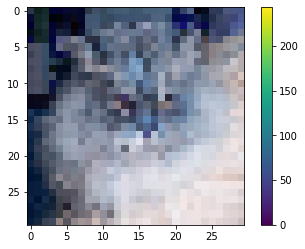

In [7]:
# show an image from the training data
plt.figure()
plt.imshow(training_data.get_image(0))
plt.colorbar()
plt.grid(False)
plt.show()

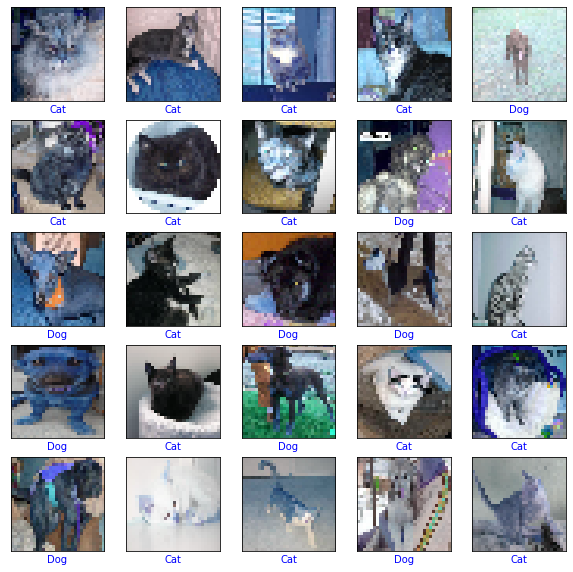

In [8]:
# verify preperation
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_data.get_image(i))
    plt.xlabel(training_data.get_label(i), color="blue")
plt.show()

In [9]:
# validate what hardware tf.keras is using for computing
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [10]:
# Create the convolutional base
model = tf.keras.models.Sequential(name="tf_model")
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(config.IMG_SIZE, config.IMG_SIZE, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

Model: "tf_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Add Dense layers on top
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(training_data.get_labels_count()))

model.summary()

Model: "tf_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                656

In [12]:
training_data.get_tf_images().get_shape()

TensorShape([24746, 30, 30, 3])

In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# train the model
history = model.fit(training_data.get_tf_images(), training_data.get_tf_labels(), epochs=config.TRAINING_EPOCHS, 
                    validation_data=(test_data.get_tf_images(), test_data.get_tf_labels()))

Epoch 1/2
774/774 [==============================] - 15s 18ms/step - loss: 2.1457 - accuracy: 0.5734 - val_loss: 0.6646 - val_accuracy: 0.6050
Epoch 2/2
774/774 [==============================] - 14s 18ms/step - loss: 0.6125 - accuracy: 0.6634 - val_loss: 0.6136 - val_accuracy: 0.6950


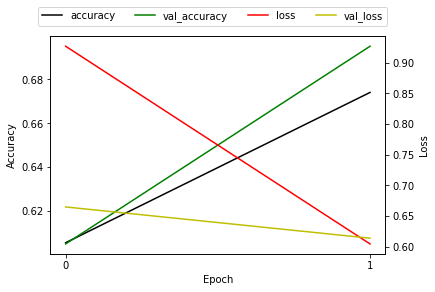

In [15]:
# Plot learning curve
fig = plt.figure()
ax1 = fig.add_subplot()
ax2 = ax1.twinx()
ax1.plot(history.history["accuracy"], label = "accuracy", color = "k")
ax1.plot(history.history["val_accuracy"], label = "val_accuracy", color = "g")
ax2.plot(history.history["loss"], label = "loss", color = "r")
ax2.plot(history.history["val_loss"], label = "val_loss", color = "y")
ax1.set_xlabel("Epoch")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Loss")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1., 0., 0.), ncol=4)

In [16]:
# evaluate model
test_loss, test_acc = model.evaluate(test_data.get_tf_images(), test_data.get_tf_labels(), verbose=2)

7/7 - 0s - loss: 0.6136 - accuracy: 0.6950


In [17]:
model

In [18]:
export_trained_model(model, config.TRAINING_EPOCHS, test_loss, test_acc, history, fig, training_data, config.MODEL_PATH)

INFO:tensorflow:Assets written to: C:\Users\MARCOW~1\AppData\Local\Temp\tmpgq_p4cck\assets
